In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import glob

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [2]:
#Loading MFCC files
mfcc_files = glob.glob('*.csv')
mfcc_data = []
for file in mfcc_files:
    df = pd.read_csv(file,header=None)
    mfcc_data.append(df)      # List of dataframes

In [3]:
def compute_variance(data):
    variance_list = []
    for mfcc_df in data:
        mfcc_variance = mfcc_df.var(axis=1)               # Calculate variance for each dataframe
        variance_list.append(mfcc_variance.values)
    variance_df = pd.DataFrame(variance_list, columns=[f'MFCC_{i+1}_variance' for i in range(20)])
    return variance_df

print(compute_variance(mfcc_data))


     MFCC_1_variance  MFCC_2_variance  MFCC_3_variance  MFCC_4_variance  \
0        6500.733653       944.563237       668.302130       521.248199   
1        2742.950395       438.938272       571.532223       291.053776   
2        6437.793762       911.165352       661.599353       381.440108   
3        2316.615861      1104.094759       710.754240       324.568785   
4        6010.976405      1093.347400       475.436665       451.748511   
..               ...              ...              ...              ...   
111      9465.014894       973.499977       534.733211       209.632404   
112      5140.441417       916.333415       447.966356       313.669992   
113      4346.225998       799.983879       475.928323       274.891923   
114      2092.024931       329.899751       592.786611       198.990187   
115      5546.460300       878.417022       638.554879       331.293709   

     MFCC_5_variance  MFCC_6_variance  MFCC_7_variance  MFCC_8_variance  \
0         286.818813    

In [4]:
mfcc_data

[       0         1         2         3         4         5         6      \
 0  -609.0396 -609.0396 -609.0396 -609.0396 -609.0396 -609.0396 -609.0396   
 1     0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 2     0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 3     0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 4     0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 5     0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 6     0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 7     0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 8     0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 9     0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 10    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
 11    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   

In [62]:
# Z-score
def apply_zscore_with_outlier_handling(mfcc_data, threshold=2):
    zscore_data = []
    for mfcc_df in mfcc_data:
        def zscore_outlier_cap(row):
            zscore_row = stats.zscore(row)
            capped_row = [min(threshold, max(-threshold, val)) for val in zscore_row]  # Cap values
            return pd.Series(capped_row)  # Ensure each row returns a Pandas Series, not a list

        zscore_df = mfcc_df.apply(zscore_outlier_cap, axis=1)       # Pandas series
        zscore_data.append(zscore_df)
    return zscore_data

zscore_outlier_data = apply_zscore_with_outlier_handling(mfcc_data)     # List of Pandas series with zscore applied
print(type(zscore_outlier_data))
print(type(zscore_outlier_data[0]))


<class 'list'>
<class 'pandas.core.frame.DataFrame'>


# **What is Winsorization?**

Winsorization is a statistical technique used to reduce the influence of outliers by limiting extreme values in a dataset. It replaces values below a certain lower percentile with the value at that percentile and above a certain upper percentile with the value at that upper percentile.

For example:

*   If the 5th percentile is 10, all values below 10 are replaced by 10.
*   If the 95th percentile is 90, all values above 90 are replaced by 90.


This helps maintain the overall structure of the data while minimizing the impact of extreme outliers.

In [37]:
def winsorize_data(mfcc_data, lower_percentile=0.05, upper_percentile=0.95):
    winsorized_data = []

    for mfcc_df in mfcc_data:
        # Calculate the lower and upper thresholds
        lower_threshold = mfcc_df.quantile(lower_percentile, axis=1)
        upper_threshold = mfcc_df.quantile(upper_percentile, axis=1)

        # Winsorize the DataFrame
        winsorized_df = mfcc_df.copy()
        for i in range(len(mfcc_df)):
            winsorized_df.iloc[i] = mfcc_df.iloc[i].clip(lower=lower_threshold[i], upper=upper_threshold[i])

        winsorized_data.append(winsorized_df)

    return winsorized_data

# Winsorized version of mfcc_data (List of MFCC dataframes)
winsorized_data = winsorize_data(mfcc_data)              # List of Pandas Dataframe


In [38]:
# Z-score with outlier handling variance table
zscore_outlier_variance_df = compute_variance(zscore_outlier_data)
print("Z-score with Outlier Handling Variance Table:")
print(zscore_outlier_variance_df.head())      # Pandas Dataframe of shape (116, 20)

# Winsorized variance table
winsorized_variance_df = compute_variance(winsorized_data)
print("\nWinsorized Variance Table:")
print(winsorized_variance_df.head())      # Pandas Dataframe of shape (116, 20)

Z-score with Outlier Handling Variance Table:
   MFCC_1_variance  MFCC_2_variance  MFCC_3_variance  MFCC_4_variance  \
0         0.725844         0.780820         0.882824         0.925203   
1         0.865909         0.885499         0.902476         0.942049   
2         0.612515         0.788670         0.897016         0.873959   
3         0.539693         0.487143         0.921689         0.927378   
4         0.582769         0.843685         0.882618         0.911905   

   MFCC_5_variance  MFCC_6_variance  MFCC_7_variance  MFCC_8_variance  \
0         0.932630         0.915038         0.918707         0.879633   
1         0.936978         0.904899         0.964441         0.921173   
2         0.908664         0.934084         0.917410         0.914018   
3         0.939907         0.933162         0.909802         0.916091   
4         0.952081         0.912226         0.887965         0.893877   

   MFCC_9_variance  MFCC_10_variance  MFCC_11_variance  MFCC_12_variance  \


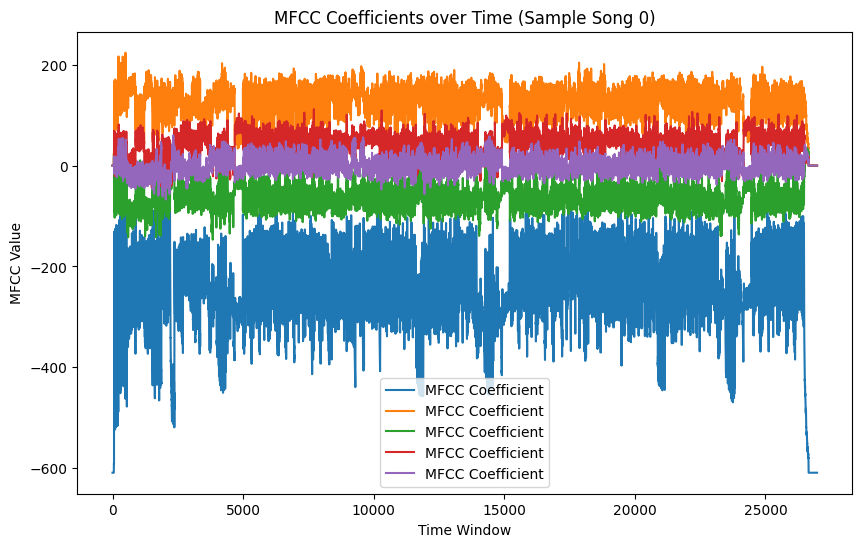

In [40]:
# Plot MFCC coefficients over time for one song (e.g., Song 0)
plt.figure(figsize=(10, 6))

for i in range(5):  # Plotting first 5 MFCC coefficients as an example
    plt.plot(mfcc_data[0].iloc[i, :], label=f'MFCC Coefficient')

plt.title('MFCC Coefficients over Time (Sample Song 0)')
plt.xlabel('Time Window')
plt.ylabel('MFCC Value')
plt.legend()
plt.show()


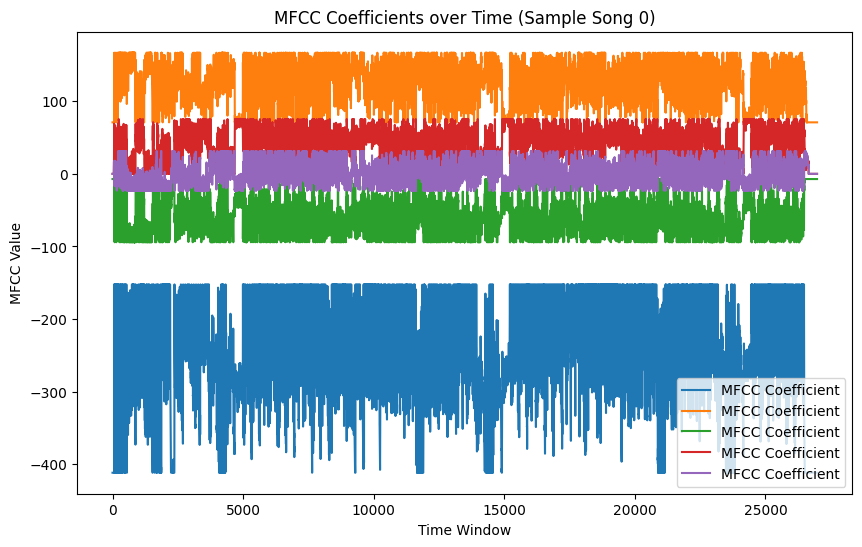

In [65]:
# Plot MFCC coefficients over time for one song (e.g., Song 0)
plt.figure(figsize=(10, 6))

for i in range(5):  # Plotting first 5 MFCC coefficients as an example
    plt.plot(winsorized_data[0].iloc[i, :], label=f'MFCC Coefficient')

plt.title('MFCC Coefficients over Time (Sample Song 0)')
plt.xlabel('Time Window')
plt.ylabel('MFCC Value')
plt.legend()
plt.show()

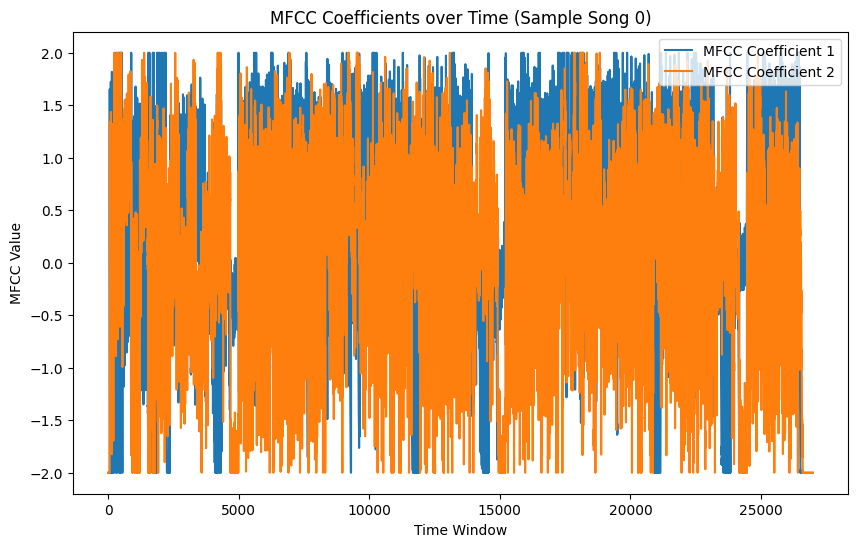

In [44]:
# Plot MFCC coefficients over time for one song (e.g., Song 0)
plt.figure(figsize=(10, 6))

for i in range(2):  # Plotting first 2 MFCC coefficients as an example
    plt.plot(zscore_outlier_data[0].iloc[i, :], label=f'MFCC Coefficient {i+1}')

plt.title('MFCC Coefficients over Time (Sample Song 0)')
plt.xlabel('Time Window')
plt.ylabel('MFCC Value')
plt.legend()
plt.show()


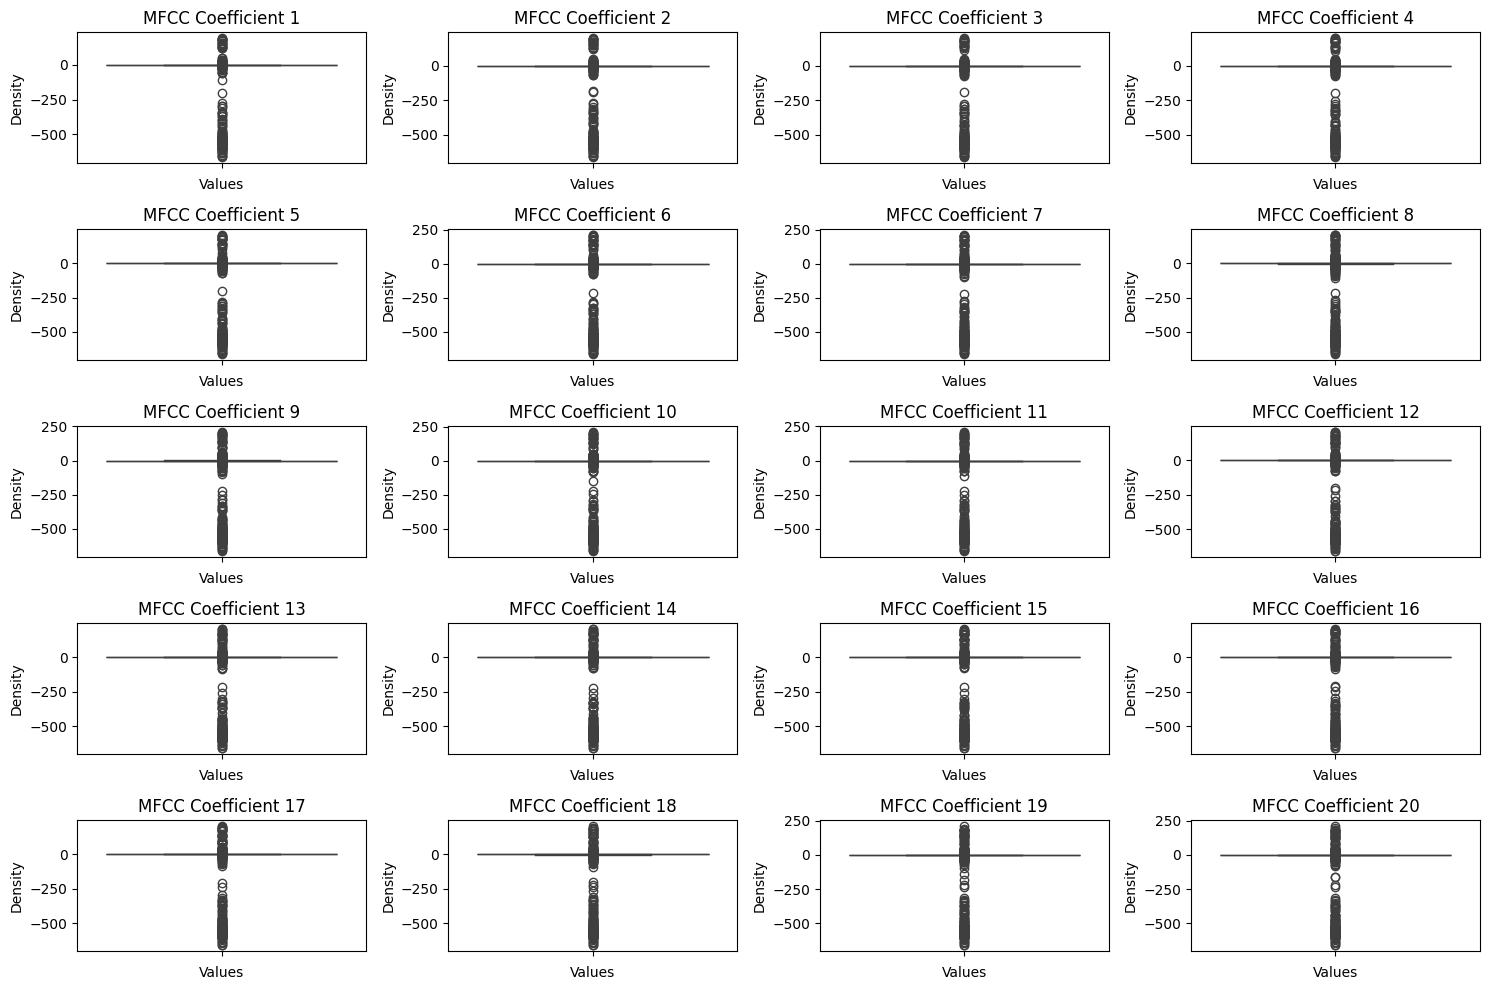

In [11]:
combined_mfcc_df = pd.concat(mfcc_data, ignore_index=True)

# Reshape the data for easier plotting
# Each row will represent an MFCC coefficient across all songs
reshaped_data = combined_mfcc_df.T  # Transpose to have MFCC coefficients as rows

# Generate box plots for each of the 20 MFCC coefficients
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(5, 4, i + 1)  # Create a grid of subplots (5 rows, 4 columns)
    sns.boxplot(data=reshaped_data.iloc[i])  # Box plot for the ith MFCC coefficient
    plt.title(f'MFCC Coefficient {i + 1}')
    plt.xlabel('Values')
    plt.ylabel('Density')

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

In [45]:
def smooth_mfcc_data(data, window_size=10):
    smoothed_data = []

    for zscore_outlier_data in data:
        # Calculate rolling mean and median (transpose to apply along columns)
        rolling_mean = zscore_outlier_data.T.rolling(window=window_size, min_periods=1).mean().T
        rolling_median = zscore_outlier_data.T.rolling(window=window_size, min_periods=1).median().T

        # Fill NaNs at the edges using ffill() and bfill() methods
        rolling_mean = rolling_mean.bfill().ffill()
        rolling_median = rolling_median.bfill().ffill()

        # Choose either rolling_mean or rolling_median to keep the same structure
        # Here we choose rolling_mean, but you can switch to rolling_median if preferred
        smoothed_data.append(rolling_mean)

    return smoothed_data

# Smooth the MFCC data
smoothed_data = smooth_mfcc_data(zscore_outlier_data)

# Convert the smoothed results back to DataFrames for easier viewing
smoothed_df = pd.concat(smoothed_data, axis=0)

# Display the first few rows of the smoothed DataFrame
print("Smoothed DataFrame (Mean):")
print(smoothed_df.head())


Smoothed DataFrame (Mean):
      0         1         2         3         4         5         6      \
0 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000   
1 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000   
2  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000   
3 -1.749876 -1.749876 -1.749876 -1.749876 -1.749876 -1.749876 -1.749876   
4 -0.152532 -0.152532 -0.152532 -0.152532 -0.152532 -0.152532 -0.152532   

      7         8         9      ...  39741  39742  39743  39744  39745  \
0 -2.000000 -2.000000 -2.000000  ...    NaN    NaN    NaN    NaN    NaN   
1 -2.000000 -2.000000 -2.000000  ...    NaN    NaN    NaN    NaN    NaN   
2  2.000000  2.000000  2.000000  ...    NaN    NaN    NaN    NaN    NaN   
3 -1.749876 -1.749876 -1.749876  ...    NaN    NaN    NaN    NaN    NaN   
4 -0.152532 -0.152532 -0.152532  ...    NaN    NaN    NaN    NaN    NaN   

   39746  39747  39748  39749  39750  
0    NaN    NaN    NaN    NaN   

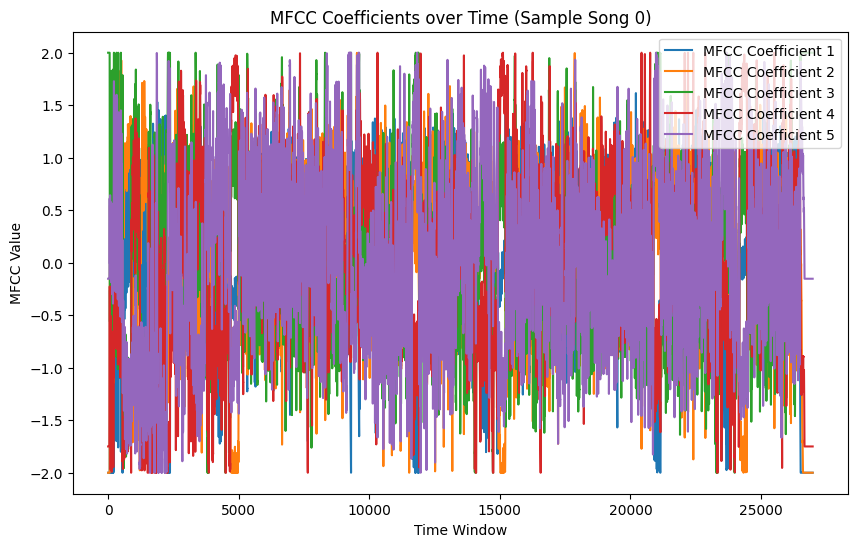

In [66]:
# Plot MFCC coefficients over time for one song (e.g., Song 0)
plt.figure(figsize=(10, 6))

for i in range(5):  # Plotting first 5 MFCC coefficients as an example
    plt.plot(smoothed_data[0].iloc[i, :], label=f'MFCC Coefficient {i+1}')

plt.title('MFCC Coefficients over Time (Sample Song 0)')
plt.xlabel('Time Window')
plt.ylabel('MFCC Value')
plt.legend()
plt.show()

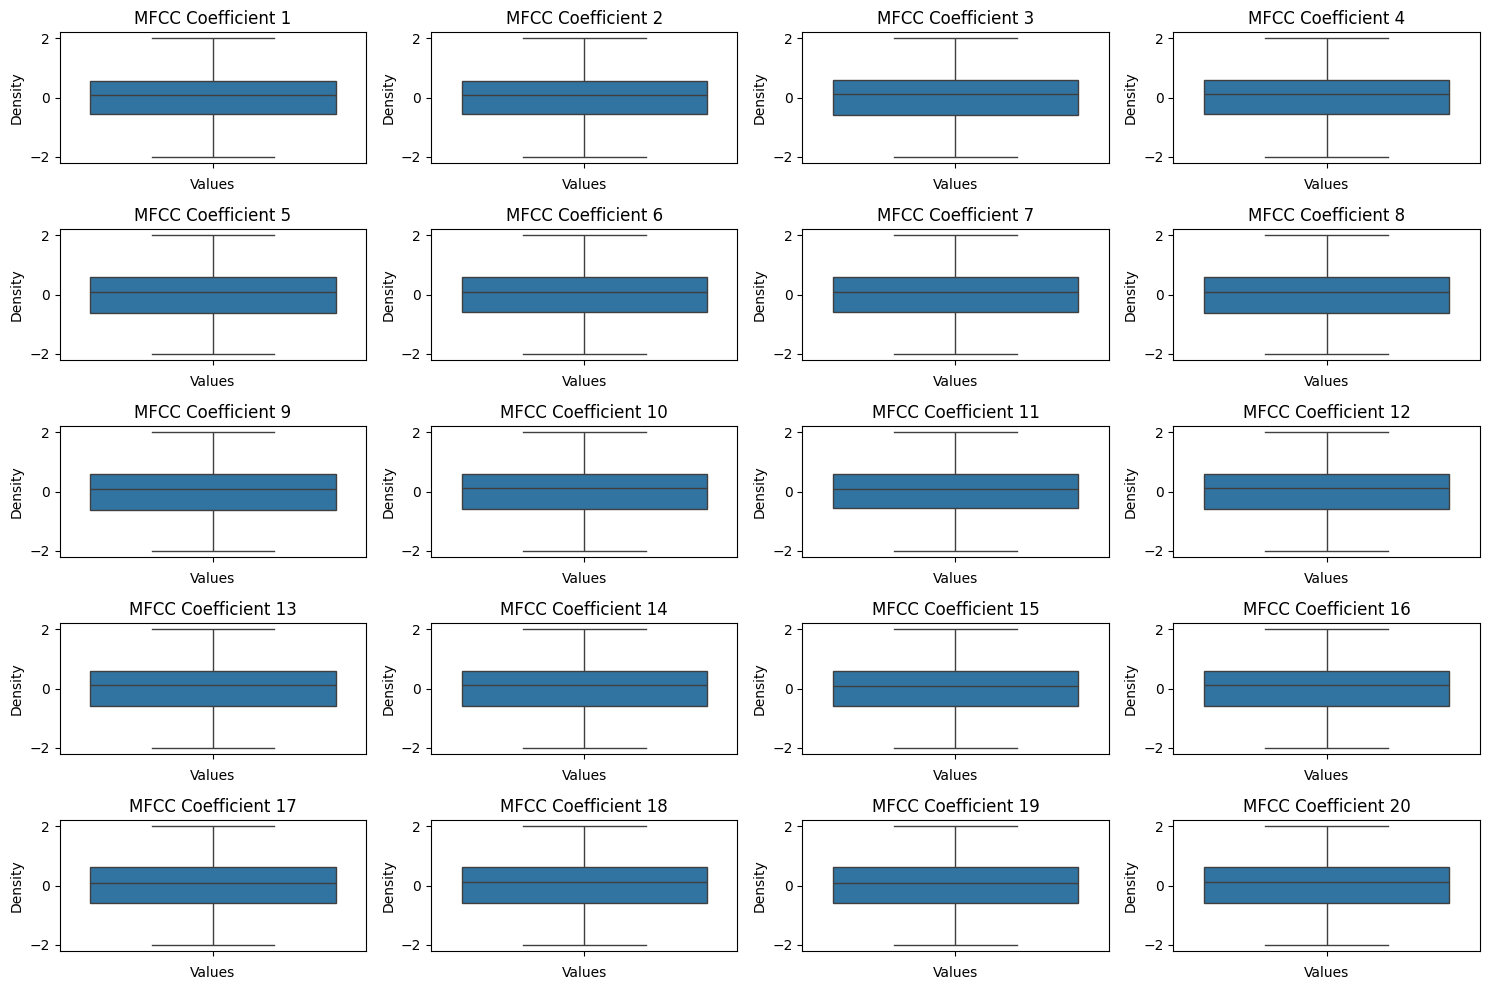

In [47]:
combined_mfcc_df = pd.concat(zscore_outlier_data, ignore_index=True)

# Reshape the data for easier plotting
# Each row will represent an MFCC coefficient across all songs
reshaped_data = combined_mfcc_df.T  # Transpose to have MFCC coefficients as rows

# Generate box plots for each of the 20 MFCC coefficients
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(5, 4, i + 1)  # Create a grid of subplots (5 rows, 4 columns)
    sns.boxplot(data=reshaped_data.iloc[i])  # Box plot for the ith MFCC coefficient
    plt.title(f'MFCC Coefficient {i + 1}')
    plt.xlabel('Values')
    plt.ylabel('Density')

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

In [67]:
# Check for missing values in each DataFrame
for index, mfcc_df in enumerate(mfcc_data):
    missing_values = mfcc_df.isnull().sum().sum()  # Total missing values in the DataFrame
    print(f"File {mfcc_files[index]}: Missing values = {missing_values}")

File 70-MFCC.csv: Missing values = 0
File 71-MFCC.csv: Missing values = 0
File 39-MFCC.csv: Missing values = 0
File 38-MFCC.csv: Missing values = 0
File 113-MFCC.csv: Missing values = 0
File 112-MFCC.csv: Missing values = 0
File 95-MFCC.csv: Missing values = 0
File 94-MFCC.csv: Missing values = 0
File 07-MFCC.csv: Missing values = 0
File 06-MFCC.csv: Missing values = 0
File 33-MFCC.csv: Missing values = 0
File 32-MFCC.csv: Missing values = 0
File 44-MFCC.csv: Missing values = 0
File 45-MFCC.csv: Missing values = 0
File 67-MFCC.csv: Missing values = 0
File 66-MFCC.csv: Missing values = 0
File 10-MFCC.csv: Missing values = 0
File 11-MFCC.csv: Missing values = 0
File 82-MFCC.csv: Missing values = 0
File 83-MFCC.csv: Missing values = 0
File 104-MFCC.csv: Missing values = 0
File 59-MFCC.csv: Missing values = 0
File 105-MFCC.csv: Missing values = 0
File 58-MFCC.csv: Missing values = 0
File 24-MFCC.csv: Missing values = 0
File 25-MFCC.csv: Missing values = 0
File 53-MFCC.csv: Missing values =

In [78]:
#Loading MFCC files
mfcc_files = glob.glob('*.csv')
song_features = []
for file in mfcc_files:
    mfcc_data = pd.read_csv(file, header=None)  # Load without header
    
    # Basic statistics
    mean_features = mfcc_data.mean(axis=1)
    var_features = mfcc_data.var(axis=1)
    skew_features = stats.skew(mfcc_data, axis=1)
    kurt_features = stats.kurtosis(mfcc_data, axis=1)
    min_features = mfcc_data.min(axis=1)
    max_features = mfcc_data.max(axis=1)
    range_features = max_features - min_features

    # Delta (first derivative) and Delta-Delta (second derivative) MFCCs
    delta_features = np.diff(mfcc_data, axis=1).mean(axis=1)  # Mean of delta
    delta_delta_features = np.diff(delta_features).mean()      # Mean of delta-delta

    # Concatenate all features into a single vector
    song_vector = np.hstack([
        mean_features, var_features, skew_features, kurt_features, 
        min_features, max_features, range_features, delta_features, delta_delta_features
    ])
    
    song_features.append(song_vector)

# Convert the list of features into a DataFrame
features_df = pd.DataFrame(song_features)
print(f"Feature matrix shape: {features_df.shape}")

Feature matrix shape: (116, 161)


In [90]:
song_features = []
for df in zscore_outlier_data:
    
    # Basic statistics
    mean_features = df.mean(axis=1)
    var_features = df.var(axis=1)
    skew_features = stats.skew(df, axis=1)
    kurt_features = stats.kurtosis(df, axis=1)
    min_features = df.min(axis=1)
    max_features = df.max(axis=1)
    range_features = max_features - min_features

    # Delta (first derivative) and Delta-Delta (second derivative) MFCCs
    delta_features = np.diff(df, axis=1).mean(axis=1)  # Mean of delta
    delta_delta_features = np.diff(delta_features).mean()      # Mean of delta-delta

    # Concatenate all features into a single vector
    song_vector = np.hstack([
        mean_features, var_features, skew_features, kurt_features, 
        min_features, max_features, range_features, delta_features, delta_delta_features
    ])
    
    song_features.append(song_vector)

# Convert the list of features into a DataFrame
features_df_zscore = pd.DataFrame(song_features)
print(f"Feature matrix shape: {features_df_zscore.shape}")

Feature matrix shape: (116, 161)


In [79]:
song_features = []
for df in winsorized_data:
    
    # Basic statistics
    mean_features = df.mean(axis=1)
    var_features = df.var(axis=1)
    skew_features = stats.skew(df, axis=1)
    kurt_features = stats.kurtosis(df, axis=1)
    min_features = df.min(axis=1)
    max_features = df.max(axis=1)
    range_features = max_features - min_features

    # Delta (first derivative) and Delta-Delta (second derivative) MFCCs
    delta_features = np.diff(df, axis=1).mean(axis=1)  # Mean of delta
    delta_delta_features = np.diff(delta_features).mean()      # Mean of delta-delta

    # Concatenate all features into a single vector
    song_vector = np.hstack([
        mean_features, var_features, skew_features, kurt_features, 
        min_features, max_features, range_features, delta_features, delta_delta_features
    ])
    
    song_features.append(song_vector)

# Convert the list of features into a DataFrame
features_df_winsorized = pd.DataFrame(song_features)
print(f"Feature matrix shape: {features_df_winsorized.shape}")

Feature matrix shape: (116, 161)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


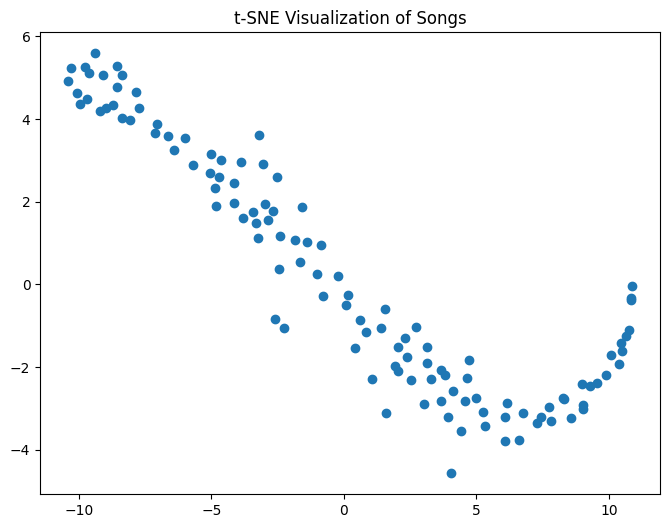

In [80]:
# PCA
# Apply PCA to reduce to 10 components for better clustering
pca = PCA(n_components=10)
pca_features = pca.fit_transform(features_df)

# Further reduce to 2D using t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(pca_features)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title("t-SNE Visualization of Songs")
plt.show()

In [92]:
from sklearn.cluster import KMeans

# Apply k-means clustering
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(pca_features)

# Assign cluster labels to the songs
features_df['Cluster'] = clusters

# Display the songs with their assigned clusters
print(features_df[['Cluster']].head())


   Cluster
0        0
1        2
2        0
3        2
4        0


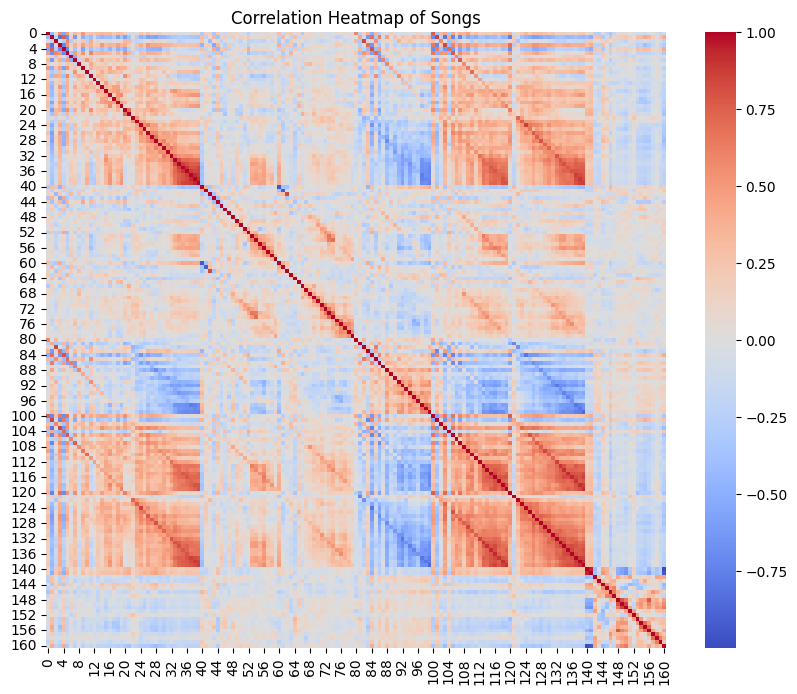

In [93]:
import seaborn as sns

# Compute the correlation matrix between songs
correlation_matrix = features_df.iloc[:, :-1].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Songs")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


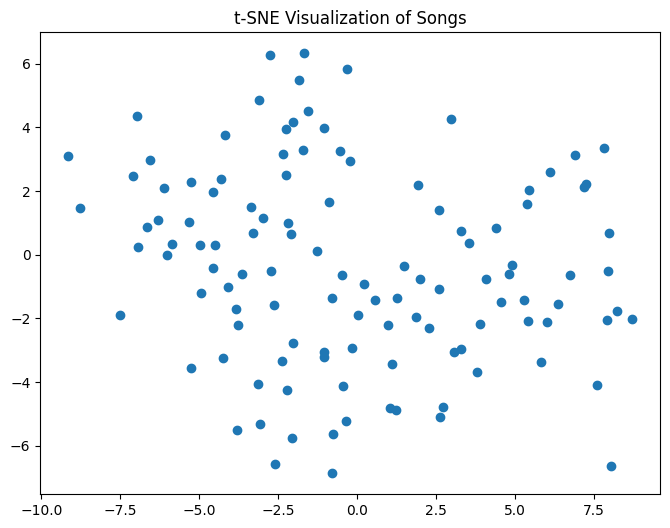

In [91]:
# PCA
# Apply PCA to reduce to 10 components for better clustering
pca = PCA(n_components=10)
pca_features_zscore = pca.fit_transform(features_df_zscore)

# Further reduce to 2D using t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results_zscore = tsne.fit_transform(pca_features_zscore)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_zscore[:, 0], tsne_results_zscore[:, 1])
plt.title("t-SNE Visualization of Songs")
plt.show()

In [94]:
from sklearn.cluster import KMeans

# Apply k-means clustering
kmeans = KMeans(n_clusters=7, random_state=42)
clusters_zscore = kmeans.fit_predict(pca_features_zscore)

# Assign cluster labels to the songs
features_df_zscore['Cluster'] = clusters_zscore

# Display the songs with their assigned clusters
print(features_df_zscore[['Cluster']].head())


   Cluster
0        4
1        1
2        3
3        3
4        3


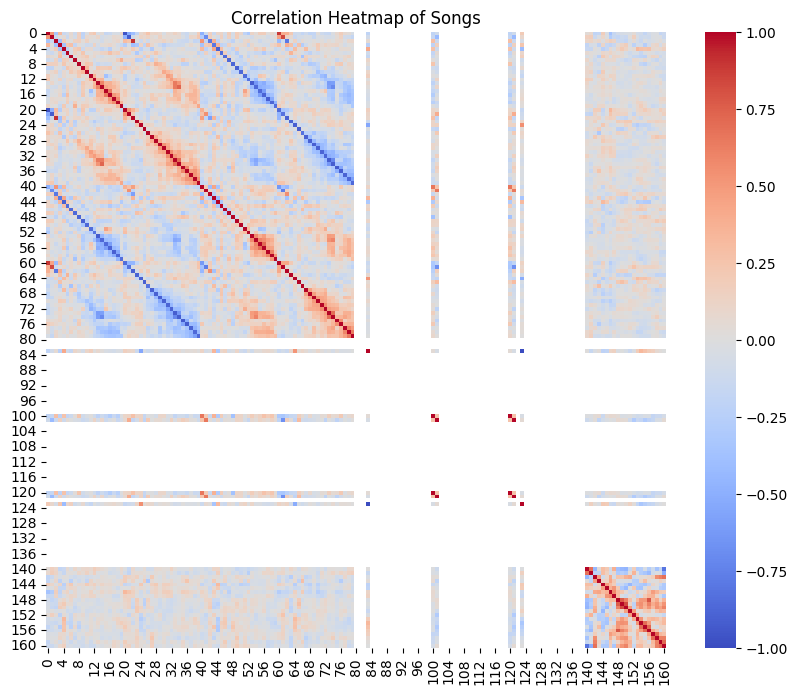

In [95]:
import seaborn as sns

# Compute the correlation matrix between songs
correlation_matrix_zscore = features_df_zscore.iloc[:, :-1].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_zscore, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Songs")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


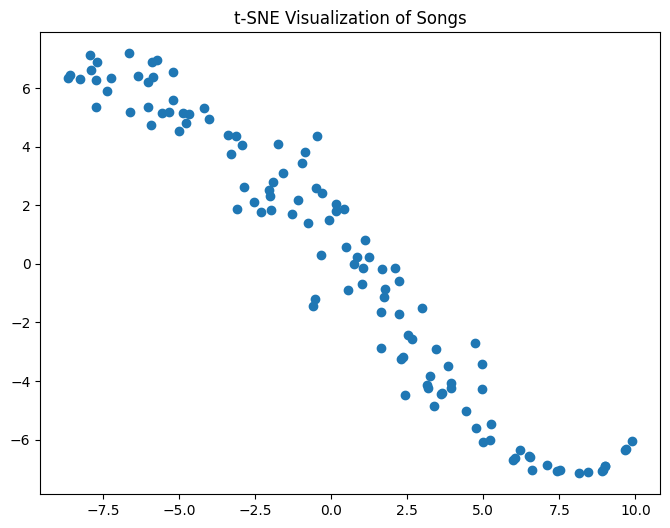

In [89]:
# PCA
# Apply PCA to reduce to 10 components for better clustering
pca = PCA(n_components=10)
pca_features_winsorized = pca.fit_transform(features_df_winsorized)

# Further reduce to 2D using t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results_winsorized = tsne.fit_transform(pca_features_winsorized)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_winsorized[:, 0], tsne_results_winsorized[:, 1])
plt.title("t-SNE Visualization of Songs")
plt.show()

In [96]:
from sklearn.cluster import KMeans

# Apply k-means clustering
kmeans = KMeans(n_clusters=7, random_state=42)
clusters_winsorized = kmeans.fit_predict(pca_features_winsorized)

# Assign cluster labels to the songs
features_df_winsorized['Cluster'] = clusters_winsorized

# Display the songs with their assigned clusters
print(features_df_winsorized[['Cluster']].head())


   Cluster
0        2
1        5
2        0
3        4
4        0


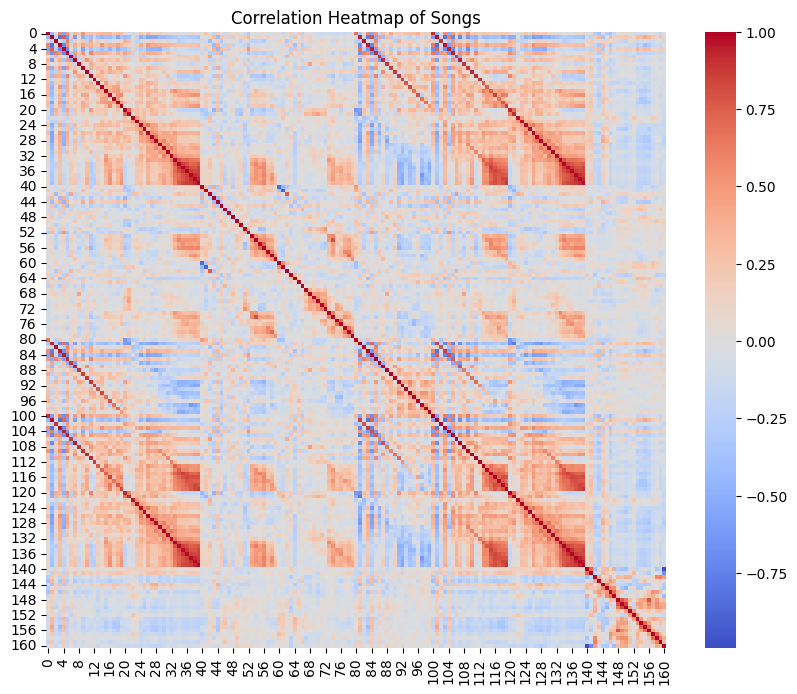

In [97]:
import seaborn as sns

# Compute the correlation matrix between songs
correlation_matrix_winsorized = features_df_winsorized.iloc[:, :-1].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_winsorized, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Songs")
plt.show()
